<a href="https://colab.research.google.com/github/hasbi2000/Mangrove_analysis/blob/main/yt5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import geemap
import ee
! pip install xee
import xee
import xarray as xr

In [ ]:
ee.Authenticate()
ee.Initialize(
    project = 'hasbihusaini',
    opt_url = 'https://earthengine-highvolume.googleapis.com'
)

In [ ]:
map = geemap.Map()
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
roi = map.draw_last_feature.geometry()

In [ ]:
landcover = ee.ImageCollection("COPERNICUS/Landcover/100m/Proba-V-C3/Global").select('discrete_classification').mean()
urban_only = landcover.lt(50).clip(roi)
landcoverfile = landcover.updateMask(urban_only)
landcover_fix = landcoverfile

In [ ]:
# map.addLayer(landcover_fix, {}, '1')

In [ ]:
mangrove = ee.ImageCollection("LANDSAT/MANGROVE_FORESTS").mean().clip(roi)

In [ ]:
# map.addLayer(mangrove, {}, '2')

In [ ]:
mangrove_samples = mangrove.sample(region=roi,scale=30,numPixels=300,seed=10,geometries=True).map(lambda f: f.set({'vegetation': 'mangrove','class': 1}))

nonmangrove_samples = landcover_fix.sample(region=roi,scale=30,numPixels=200,seed=10,geometries=True).map(lambda f: f.set({'vegetation': 'nonmangrove','class': 0}))

In [ ]:
training_samples = mangrove_samples.merge(nonmangrove_samples)
training_samples
print('Total training samples:', training_samples.size().getInfo())

Total training samples: 100


In [ ]:
# map.addLayer(nonmangrove_samples, {}, 'nonmangrove')
# map.addLayer(mangrove_samples, {}, 'mangrove')

In [ ]:
# training_samples

In [ ]:
# start_date = '2018-01-01'
# end_date = '2023-12-31'

def add_indices(image):
    nir = image.select('B8')
    red = image.select('B4')
    swir1 = image.select('B11')
    green = image.select('B3')
    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')
    ndmi = nir.subtract(swir1).divide(nir.add(swir1)).rename('NDMI')
    mndwi = green.subtract(swir1).divide(green.add(swir1)).rename('MNDWI')
    sr = nir.divide(red).rename('SR')
    r54 = swir1.divide(nir).rename('R54')
    r35 = red.divide(swir1).rename('R35')
    gcvi = nir.divide(green).subtract(1).rename('GCVI')
    return image.addBands([ndvi, ndmi, mndwi, sr, r54, r35, gcvi])

bands_to_select = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']
sentinel = ee.ImageCollection("COPERNICUS/S2_SR").filterDate(start_date, end_date).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).select(bands_to_select).map(add_indices)

composite = sentinel.mean().clip(roi)

dem = ee.Image("USGS/SRTMGL1_003").clip(roi)
elevation_mask = dem.lt(65)

ndvi_mask = composite.select('NDVI').gt(0.25)
mndwi_mask = composite.select('MNDWI').gt(-0.50)

cmps = composite.updateMask(ndvi_mask).updateMask(mndwi_mask).updateMask(elevation_mask)

bands = ['B8', 'B11', 'B4', 'NDVI', 'NDMI', 'MNDWI', 'SR', 'GCVI']
image1 = cmps.select(bands)

In [ ]:
samples = image1.sampleRegions(collection=training_samples,properties=['vegetation', 'class'],scale=30).randomColumn('random')

In [ ]:
split = 0.7
training = samples.filter(ee.Filter.lt('random', split))
testing = samples.filter(ee.Filter.gte('random', split))
testing

In [ ]:
print('Total testing samples:', testing.size().getInfo())

Total testing samples: 19


In [ ]:
# training

In [ ]:
bands = ['B8', 'B11', 'B4', 'NDVI', 'NDMI', 'MNDWI', 'SR', 'GCVI']
classifier = ee.Classifier.smileRandomForest(100).train(features=training,classProperty='class',inputProperties=bands)

In [ ]:
validation = testing.classify(classifier)
testAccuracy = validation.errorMatrix('class', 'classification')
print('Validation error matrix RF', testAccuracy.getInfo())
print('Validation overall accuracy RF', testAccuracy.accuracy().getInfo())

Validation error matrix RF [[6, 1], [2, 10]]
Validation overall accuracy RF 0.8421052631578947


In [ ]:
sentinel = ee.ImageCollection("COPERNICUS/S2_SR").filterDate(start_date, end_date).filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).select(bands_to_select).map(add_indices)
composite2018 = sentinel.filterDate('2018-01-01','2018-12-31').mean().clip(roi)
cmps2018 = composite2018.updateMask(ndvi_mask).updateMask(mndwi_mask).updateMask(elevation_mask)
image2018 = cmps2018.select(bands)
composite2019 = sentinel.filterDate('2019-01-01','2019-12-31').mean().clip(roi)
cmps2019 = composite2019.updateMask(ndvi_mask).updateMask(mndwi_mask).updateMask(elevation_mask)
image2019 = cmps2019.select(bands)
composite2020 = sentinel.filterDate('2020-01-01','2020-12-31').mean().clip(roi)
cmps2020 = composite2020.updateMask(ndvi_mask).updateMask(mndwi_mask).updateMask(elevation_mask)
image2020 = cmps2020.select(bands)
composite2021 = sentinel.filterDate('2021-01-01','2021-12-31').mean().clip(roi)
cmps2021 = composite2021.updateMask(ndvi_mask).updateMask(mndwi_mask).updateMask(elevation_mask)
image2021 = cmps2021.select(bands)

In [ ]:
# image2018

In [ ]:
# image2019

In [ ]:
# image2020

In [ ]:
# image2021

In [ ]:
classified2018 = image2018.select(['B8', 'B11', 'B4', 'NDVI', 'NDMI', 'MNDWI', 'SR', 'GCVI']).classify(classifier)
pixelcount2018 = classified2018.connectedPixelCount(100, False);
countmask2018 = pixelcount2018.select(0).gt(15)

classified2019 = image2019.select(['B8', 'B11', 'B4', 'NDVI', 'NDMI', 'MNDWI', 'SR', 'GCVI']).classify(classifier)
pixelcount2019 = classified2019.connectedPixelCount(100, False);
countmask2019 = pixelcount2019.select(0).gt(15)

classified2020 = image2020.select(['B8', 'B11', 'B4', 'NDVI', 'NDMI', 'MNDWI', 'SR', 'GCVI']).classify(classifier)
pixelcount2020 = classified2020.connectedPixelCount(100, False);
countmask2020 = pixelcount2020.select(0).gt(15)

classified2021 = image2021.select(['B8', 'B11', 'B4', 'NDVI', 'NDMI', 'MNDWI', 'SR', 'GCVI']).classify(classifier)
pixelcount2021 = classified2021.connectedPixelCount(100, False);
countmask2021 = pixelcount2021.select(0).gt(15)

classmask2018 = classified2018.select('classification').eq(1);
classed2018 = classified2018.updateMask(countmask2018).updateMask(classmask2018);
classed2018

classmask2019 = classified2019.select('classification').eq(1);
classed2019 = classified2019.updateMask(countmask2019).updateMask(classmask2019);
classed2019

classmask2020 = classified2020.select('classification').eq(1);
classed2020 = classified2020.updateMask(countmask2020).updateMask(classmask2020);
classed2020

classmask2021 = classified2021.select('classification').eq(1);
classed2021 = classified2021.updateMask(countmask2021).updateMask(classmask2021);
classed2021

In [ ]:
# vis_params = {'min': 0, 'max': 0.1, 'palette': ['red']}

In [ ]:
# map.addLayer(classed2018, vis_params, '2018')
# map.addLayer(classed2019, vis_params, '2019')
# map.addLayer(classed2020, vis_params, '2020')
# map.addLayer(classed2021, vis_params, '2021')

In [ ]:
ts_collection = ee.ImageCollection([classed2018, classed2019, classed2020, classed2021])

In [ ]:
ds = xr.open_dataset(ts_collection, engine = 'ee', crs = 'EPSG:4326', scale = 0.0001, geometry = roi )
# ds_1 = ds.rename({'NDVI': 'Above_Carbon'})
ds

<xarray.Dataset> Size: 6MB
Dimensions:         (time: 4, lon: 714, lat: 558)
Coordinates:
  * time            (time) int64 32B 0 1 2 3
  * lon             (lon) float64 6kB 98.7 98.7 98.7 98.7 ... 98.77 98.77 98.77
  * lat             (lat) float64 4kB 3.732 3.733 3.733 ... 3.788 3.788 3.788
Data variables:
    classification  (time, lon, lat) float32 6MB ...
Attributes:
    crs:      EPSG:4326

In [ ]:
import matplotlib.pyplot as plt

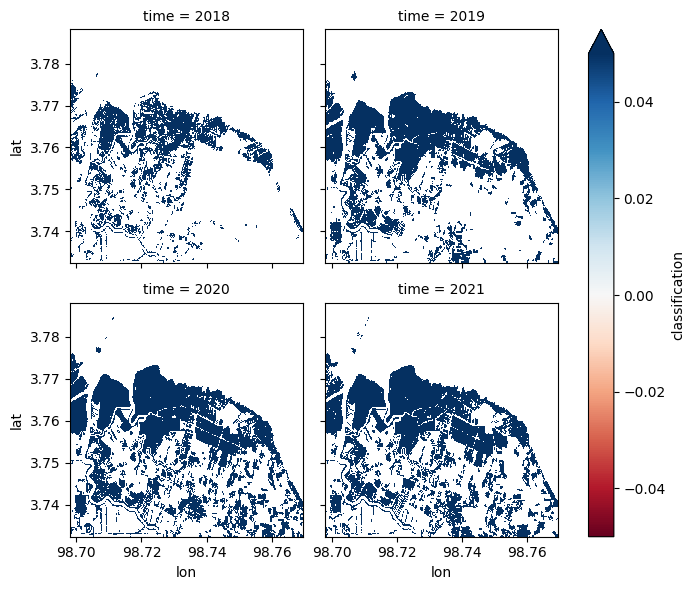

In [ ]:
ds = ds.assign_coords(time=['2018', '2019', '2020', '2021'])
ds['classification'].plot(x = 'lon', y = 'lat', cmap = 'RdBu', col = 'time', col_wrap = 2, robust = True, vmin = 0, vmax = 0)
plt.savefig('ndci_facet_plot.png', dpi=600, bbox_inches='tight')

In [ ]:
area2018 = classed2018.multiply(ee.Image.pixelArea()).divide(10000).reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=30,
    maxPixels=1e13,
    tileScale=16
).get('classification')

print(area2018.getInfo(), 'Mangrove 2018 (ha)')

610.5230736840368 Mangrove 2018 (ha)


In [ ]:
area2019 = classed2019.multiply(ee.Image.pixelArea()).divide(10000).reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=30,
    maxPixels=1e13,
    tileScale=16
).get('classification')

print(area2019.getInfo(), 'Mangrove 2018 (ha)')

1069.6204354992406 Mangrove 2018 (ha)


In [ ]:
area2020 = classed2020.multiply(ee.Image.pixelArea()).divide(10000).reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=30,
    maxPixels=1e13,
    tileScale=16
).get('classification')

print(area2020.getInfo(), 'Mangrove 2020 (ha)')

1395.804977786906 Mangrove 2020 (ha)


In [ ]:
area2021 = classed2021.multiply(ee.Image.pixelArea()).divide(10000).reduceRegion(
    reducer=ee.Reducer.sum(),
    geometry=roi,
    scale=30,
    maxPixels=1e13,
    tileScale=16
).get('classification')

print(area2021.getInfo(), 'Mangrove 2021 (ha)')

1345.3248893166144 Mangrove 2021 (ha)
